In [5]:
import os
import shutil
import random

# -------------------------
# 🔹 Define Directories
# -------------------------
dataset_dir = 'Oxford-IIIT-Pet'
images_dir = os.path.join(dataset_dir, 'images')
output_dir = 'Oxford-IIIT-Pet_Split'  # New directory to store the split data

# -------------------------
# 🔹 Create New Directories for Train, Test, and Validation Data
# -------------------------
def create_split_directories():
    for split in ['train', 'val', 'test']:
        for class_name in os.listdir(images_dir):
            # Create class-wise directories in each split folder
            class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(class_dir, exist_ok=True)

# -------------------------
# 🔹 Split Data into Train/Val/Test
# -------------------------
def split_data():
    for class_name in os.listdir(images_dir):
        class_dir = os.path.join(images_dir, class_name)
        if os.path.isdir(class_dir):
            # Get all image files in the class folder
            image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]

            # Shuffle image files for randomness
            random.shuffle(image_files)

            # Determine split sizes
            total_images = len(image_files)
            train_size = int(total_images * 0.7)
            val_size = int(total_images * 0.15)
            test_size = total_images - train_size - val_size

            # Split the images into train, validation, and test sets
            train_images = image_files[:train_size]
            val_images = image_files[train_size:train_size + val_size]
            test_images = image_files[train_size + val_size:]

            # Move the images to corresponding directories
            for img in train_images:
                shutil.move(os.path.join(class_dir, img), os.path.join(output_dir, 'train', class_name, img))
            for img in val_images:
                shutil.move(os.path.join(class_dir, img), os.path.join(output_dir, 'val', class_name, img))
            for img in test_images:
                shutil.move(os.path.join(class_dir, img), os.path.join(output_dir, 'test', class_name, img))

# -------------------------
# 🔹 Run the Split Process
# -------------------------
create_split_directories()
split_data()

print("Dataset has been split into train, validation, and test directories.")


Dataset has been split into train, validation, and test directories.


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -------------------------
# 🔹 Load Oxford Pets Dataset using TensorFlow
# -------------------------
def load_data():
    # Directories for Oxford Pets Dataset
    train_dir = 'Oxford-IIIT-Pet_Split/train/'
    val_dir = 'Oxford-IIIT-Pet_Split/val/'

    # Use ImageDataGenerator for easier data loading and augmentation
    train_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)

    # Load the training data with augmentation
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),  # Resize images to 64x64
        batch_size=64,
        class_mode='categorical'  # For multi-class classification
    )

    # Load the validation data
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(64, 64),  # Resize images to 64x64
        batch_size=64,
        class_mode='categorical'  # For multi-class classification
    )

    # Get the number of classes (37 in this case for Oxford Pets dataset)
    num_classes = len(train_generator.class_indices)

    return train_generator, val_generator, num_classes

# -------------------------
# 🔹 Build Model (ResNet50)
# -------------------------
def build_model(num_classes):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

    # Custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

    return model

# -------------------------
# 🔹 Train and Evaluate Model
# -------------------------
def train_and_evaluate():
    train_generator, val_generator, num_classes = load_data()
    model = build_model(num_classes)

    print("\n--- Training on Oxford Pets Dataset ---")
    history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1)

    print("\n--- Evaluating on Full Dataset ---")
    y_pred = np.argmax(model.predict(val_generator), axis=1)
    y_true = val_generator.classes

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return model, val_generator, y_pred, y_true, cm

# -------------------------
# 🔹 Run Training & Evaluation
# -------------------------
trained_model, val_generator, val_preds, val_labels, final_cm = train_and_evaluate()

# -------------------------
# 🔹 Plot Normalized Confusion Matrix for Oxford Pets Dataset
# -------------------------
def plot_confusion_matrix(cm, labels):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=False, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Final Normalized Confusion Matrix (Oxford Pets Dataset)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Labels for Oxford Pets dataset
oxford_pets_labels = list(val_generator.class_indices.keys())
plot_confusion_matrix(final_cm, oxford_pets_labels)


Found 0 images belonging to 7393 classes.
Found 0 images belonging to 7393 classes.


I0000 00:00:1742944747.765366 3152824 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:e1:00.0, compute capability: 8.0



--- Training on Oxford Pets Dataset ---


/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

Found 9881 images belonging to 5 classes.
Found 1082 images belonging to 5 classes.

--- Training on Sports Video Data ---
Epoch 1/20


/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.6569 - loss: 0.9330 - val_accuracy: 0.2255 - val_loss: 3.9588
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9835 - loss: 0.0619 - val_accuracy: 0.1645 - val_loss: 6.0254
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.9948 - loss: 0.0190 - val_accuracy: 0.2394 - val_loss: 2.9620
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.9969 - loss: 0.0110 - val_accuracy: 0.3577 - val_loss: 2.4612
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.5018 - val_loss: 3.1463
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.9964 - loss: 0.0127 - val_accuracy: 0.8013 - val_loss: 0.9020
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.9951 - loss: 0.0157 - val_accuracy: 0.9584 - val_loss: 0.2529
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.9961 - loss: 0.0130 - val_accura

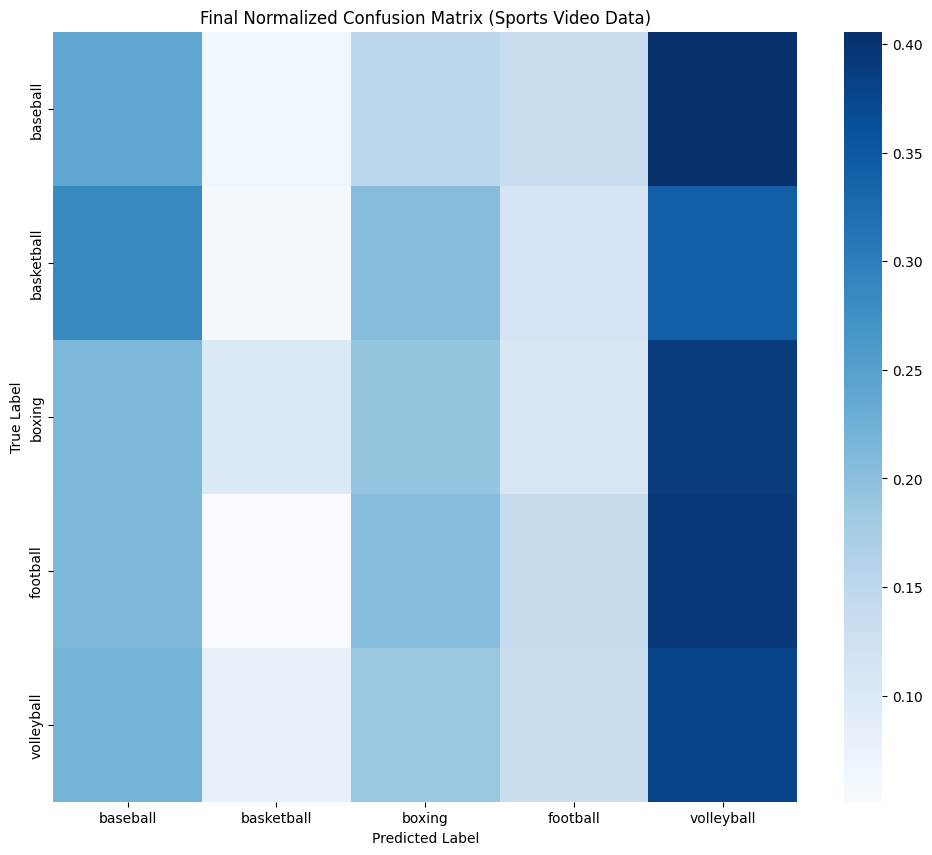

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -------------------------
# 🔹 Load Sports Video Data using TensorFlow
# -------------------------
def load_data():
    # Directories for sports video data
    train_dir = '../Midterm/sports-video-data/train_images/'
    val_dir = '../Midterm/sports-video-data/val_images/'

    # Use ImageDataGenerator for easier data loading and augmentation
    train_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)

    # Load the training data with augmentation
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),  # Resize images to 64x64
        batch_size=64,
        class_mode='categorical'  # For multi-class classification
    )

    # Load the validation data
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(64, 64),  # Resize images to 64x64
        batch_size=64,
        class_mode='categorical'  # For multi-class classification
    )

    # Get the number of classes (5 in your case)
    num_classes = len(train_generator.class_indices)

    return train_generator, val_generator, num_classes

# -------------------------
# 🔹 Build Model (ResNet50)
# -------------------------
def build_model(num_classes):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

    # Custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

    return model

# -------------------------
# 🔹 Train and Evaluate Model
# -------------------------
def train_and_evaluate():
    train_generator, val_generator, num_classes = load_data()
    model = build_model(num_classes)

    print("\n--- Training on Sports Video Data ---")
    history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1)

    print("\n--- Evaluating on Full Dataset ---")
    y_pred = np.argmax(model.predict(val_generator), axis=1)
    y_true = val_generator.classes

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return model, val_generator, y_pred, y_true, cm

# -------------------------
# 🔹 Run Training & Evaluation
# -------------------------
trained_model, val_generator, val_preds, val_labels, final_cm = train_and_evaluate()

# -------------------------
# 🔹 Plot Normalized Confusion Matrix for Sports Video Data
# -------------------------
def plot_confusion_matrix(cm, labels):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=False, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Final Normalized Confusion Matrix (Sports Video Data)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Labels for the sports video classes (based on the folder names)
sports_video_labels = list(val_generator.class_indices.keys())
plot_confusion_matrix(final_cm, sports_video_labels)


In [3]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# 🔹 Save the Trained Model
# -------------------------
model_filename = "sports_video_resnet50_model.h5"
trained_model.save(model_filename)
print(f"Model saved as {model_filename}")

# -------------------------
# 🔹 Load Sports Video Labels (Human Readable)
# -------------------------
sports_video_label_names = ['baseball', 'basketball', 'boxing', 'football', 'volleyball']

# -------------------------
# 🔹 Display 50 Random Predictions with True Labels
# -------------------------
def visualize_predictions(model, val_generator, num_samples=50):
    # Get random sample indices
    indices = random.sample(range(len(val_generator)), num_samples)

    # Prepare figure for visualization
    plt.figure(figsize=(15, 15))
    
    for i, idx in enumerate(indices):
        image, true_label = val_generator[idx]
        true_label_name = sports_video_label_names[true_label]
        predicted_label_idx = np.argmax(model.predict(image))
        predicted_label_name = sports_video_label_names[predicted_label_idx]

        # Plot the image with true and predicted labels
        plt.subplot(10, 5, i + 1)
        plt.imshow(image[0])  # Get the image from the batch
        plt.axis('off')
        plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}")

    plt.tight_layout()
    plt.show()

# -------------------------
# 🔹 Run Visualization on Validation Set
# -------------------------
visualize_predictions(trained_model, val_generator)


Model saved as sports_video_resnet50_model.h5


ValueError: Sample larger than population or is negative

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# 🔹 Plot Training and Validation Accuracy
# -------------------------
def plot_training_accuracy(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 6))
    
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# -------------------------
# 🔹 Train the Model and Plot Accuracy
# -------------------------
def train_and_plot_accuracy():
    # Load the data and create the model
    train_generator, val_generator, num_classes = load_data()
    model = build_model(num_classes)

    # Train the model and save the training history
    print("\n--- Training the Model on Sports Video Data ---")
    history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1)

    # Plot the training and validation accuracy
    plot_training_accuracy(history)

# -------------------------
# 🔹 Run Training and Plot Accuracy
# -------------------------
train_and_plot_accuracy()
